In [1]:
# EfficientNetB0 for Breast Cancer Classification
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score

# Set seeds for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Project paths
ROOT = Path(r"d:\Computer Science\UoL\Final Project\breast-cancer-detection")
DATA_DIR = ROOT / "data"
MODELS_DIR = ROOT / "models"
FIGURES_DIR = ROOT / "figures"

# Create directories
MODELS_DIR.mkdir(exist_ok=True)
FIGURES_DIR.mkdir(exist_ok=True)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.19.0
GPU available: []


In [2]:
# Load the CSV with image paths and labels
df = pd.read_csv(DATA_DIR / "df_imgs_densenet.csv")

print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

# We only need image_path and label columns
df_clean = df[['image_path', 'label', 'split']].copy()

# Convert paths to strings and verify they exist
df_clean['image_path'] = df_clean['image_path'].astype(str)
df_clean['label'] = df_clean['label'].astype(int)

# Check a sample path exists
sample_path = Path(df_clean.iloc[0]['image_path'])
print(f"\nSample path exists: {sample_path.exists()}")
print(f"\nLabel distribution:")
print(df_clean['label'].value_counts())
print(f"\nSplit distribution:")
print(df_clean['split'].value_counts())

Dataset shape: (3568, 25)
Columns: ['patient_id', 'breast density', 'left or right breast', 'image view', 'abnormality id', 'abnormality type', 'calc type', 'calc distribution', 'assessment', 'pathology', 'subtlety', 'source_path', 'cropped image file path', 'ROI mask file path', 'lesion_type', 'split', 'breast_density', 'mass shape', 'mass margins', 'label', 'case_uid', 'source_uid', 'jpeg_uid', 'image_path', 'mask_path']

Sample path exists: True

Label distribution:
label
0    2111
1    1457
Name: count, dtype: int64

Split distribution:
split
train    2864
test      704
Name: count, dtype: int64


In [3]:
# Separate by existing split column
train_df = df_clean[df_clean['split'] == 'train'].copy()
test_df = df_clean[df_clean['split'] == 'test'].copy()

# Create validation set from training data (80/20 split)
train_df, val_df = train_test_split(
    train_df, 
    test_size=0.2, 
    stratify=train_df['label'],
    random_state=SEED
)

print(f"Train samples: {len(train_df)} ({train_df['label'].value_counts().to_dict()})")
print(f"Val samples: {len(val_df)} ({val_df['label'].value_counts().to_dict()})")
print(f"Test samples: {len(test_df)} ({test_df['label'].value_counts().to_dict()})")

# Calculate class weights for imbalanced dataset
n_benign = (train_df['label'] == 0).sum()
n_malignant = (train_df['label'] == 1).sum()
total = len(train_df)

class_weight = {
    0: total / (2 * n_benign),
    1: total / (2 * n_malignant)
}
print(f"\nClass weights: {class_weight}")

Train samples: 2291 ({0: 1346, 1: 945})
Val samples: 573 ({0: 337, 1: 236})
Test samples: 704 ({0: 428, 1: 276})

Class weights: {0: np.float64(0.8510401188707281), 1: np.float64(1.2121693121693122)}


In [4]:
# Data pipeline parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

def load_and_preprocess_image(image_path, label):
    """Load and preprocess a single image"""
    # Read image file
    image = tf.io.read_file(image_path)
    # Decode JPEG
    image = tf.io.decode_jpeg(image, channels=1)  # Grayscale mammograms
    # Convert to RGB (EfficientNet expects 3 channels)
    image = tf.image.grayscale_to_rgb(image)
    # Resize
    image = tf.image.resize(image, IMG_SIZE)
    # EfficientNet expects pixels in [0, 255] range
    image = tf.cast(image, tf.float32)
    
    return image, tf.cast(label, tf.float32)

def create_dataset(dataframe, training=False):
    """Create tf.data.Dataset from dataframe"""
    # Get paths and labels
    image_paths = dataframe['image_path'].values
    labels = dataframe['label'].values
    
    # Create dataset
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    
    # Shuffle if training
    if training:
        dataset = dataset.shuffle(buffer_size=len(dataframe), seed=SEED)
    
    # Map preprocessing function
    dataset = dataset.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
    
    # Batch and prefetch
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE)
    
    return dataset

# Create datasets
train_ds = create_dataset(train_df, training=True)
val_ds = create_dataset(val_df, training=False)
test_ds = create_dataset(test_df, training=False)

# Verify datasets
for images, labels in train_ds.take(1):
    print(f"Image batch shape: {images.shape}")
    print(f"Label batch shape: {labels.shape}")
    print(f"Image value range: [{tf.reduce_min(images):.1f}, {tf.reduce_max(images):.1f}]")

Image batch shape: (32, 224, 224, 3)
Label batch shape: (32,)
Image value range: [0.0, 255.0]


In [5]:
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, AUC

# Build ResNet50V2 model instead
def build_resnet_model():
    model = Sequential([
        ResNet50V2(
            include_top=False,
            weights='imagenet',
            input_shape=(224, 224, 3),
            pooling=None
        ),
        GlobalAveragePooling2D(),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ], name='ResNet50V2_BreastCancer')
    
    # Get reference to base model
    base_model = model.layers[0]
    base_model.trainable = False
    
    return model, base_model

model, base_model = build_resnet_model()

# Compile model
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)

print(f"✅ ResNet50V2 model built successfully")
print(f"Total parameters: {model.count_params():,}")
print(f"Trainable parameters: {sum(tf.size(w).numpy() for w in model.trainable_weights):,}")

✅ ResNet50V2 model built successfully
Total parameters: 23,827,201
Trainable parameters: 262,401


In [7]:
# lets sanity check train_ds to see if images are feeding through correctly to the model training pipeline
for images, labels in train_ds.take(1):
    print(f"Image batch shape: {images.shape}")
    print(f"Label batch shape: {labels.shape}")
    print(f"Image value range: [{tf.reduce_min(images):.1f}, {tf.reduce_max(images):.1f}]")

Image batch shape: (32, 224, 224, 3)
Label batch shape: (32,)
Image value range: [0.0, 255.0]


Text(0.5, 1.0, 'Label: 1.0')

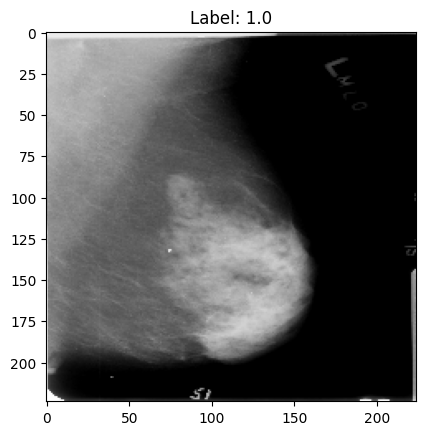

In [8]:
# print random image from batch
import matplotlib.pyplot as plt
plt.imshow(images[0].numpy().astype("uint8"))
plt.title(f"Label: {labels[0].numpy()}")

In [9]:
# Callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

callbacks = [
    ModelCheckpoint(
        str(MODELS_DIR / 'resnet50v2_best.keras'),
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        min_lr=1e-7,
        verbose=1
    )
]

# Initial training with frozen base
INITIAL_EPOCHS = 3

print("Starting initial training with frozen base model...")
history_initial = model.fit(
    train_ds,
    epochs=INITIAL_EPOCHS,
    validation_data=val_ds,
    class_weight=class_weight,
    callbacks=callbacks,
    verbose=1
)

print("✅ Initial training complete")

Starting initial training with frozen base model...
Epoch 1/3
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5110 - loss: 2.6079 - precision: 0.4346 - recall: 0.5351
Epoch 1: val_accuracy improved from None to 0.58813, saving model to d:\Computer Science\UoL\Final Project\breast-cancer-detection\models\resnet50v2_best.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 176s 2s/step - accuracy: 0.5369 - loss: 1.5132 - precision: 0.4379 - recall: 0.4328 - val_accuracy: 0.5881 - val_loss: 0.6922 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/3
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5584 - loss: 0.7659 - precision: 0.4191 - recall: 0.1659
Epoch 2: val_accuracy did not improve from 0.58813
72/72 ━━━━━━━━━━━━━━━━━━━━ 162s 2s/step - accuracy: 0.5657 - loss: 0.7391 - precision: 0.4214 - recall: 0.1418 - val_accuracy: 0.5881 - val_loss: 0.6920 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/3
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s

In [10]:
# Unfreeze top layers of base model for fine-tuning
base_model.trainable = True

# Fine-tune from this layer onwards (freeze bottom 80% of layers)
fine_tune_at = int(len(base_model.layers) * 0.8)

# Freeze layers
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

print(f"Unfreezing top {len(base_model.layers) - fine_tune_at} layers of {len(base_model.layers)} total")

# Recompile with lower learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy', 
             Precision(name='precision'), 
             Recall(name='recall'), 
             AUC(name='auc')]
)

# Continue training
FINE_TUNE_EPOCHS = 7

print("Starting fine-tuning...")
history_fine = model.fit(
    train_ds,
    epochs=FINE_TUNE_EPOCHS,
    validation_data=val_ds,
    class_weight=class_weight,
    callbacks=callbacks,
    verbose=1
)

print("✅ Fine-tuning complete")

Unfreezing top 38 layers of 190 total
Starting fine-tuning...
Epoch 1/7
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5798 - auc: 0.5603 - loss: 0.6866 - precision: 0.4713 - recall: 0.3568
Epoch 1: val_accuracy did not improve from 0.58813
72/72 ━━━━━━━━━━━━━━━━━━━━ 227s 3s/step - accuracy: 0.5853 - auc: 0.5797 - loss: 0.6868 - precision: 0.4963 - recall: 0.3545 - val_accuracy: 0.5812 - val_auc: 0.5480 - val_loss: 0.6858 - val_precision: 0.4524 - val_recall: 0.0805 - learning_rate: 1.0000e-05
Epoch 2/7
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6339 - auc: 0.6641 - loss: 0.6696 - precision: 0.5614 - recall: 0.4384
Epoch 2: val_accuracy did not improve from 0.58813
72/72 ━━━━━━━━━━━━━━━━━━━━ 198s 3s/step - accuracy: 0.6377 - auc: 0.6781 - loss: 0.6670 - precision: 0.5800 - recall: 0.4413 - val_accuracy: 0.5881 - val_auc: 0.6065 - val_loss: 0.6724 - val_precision: 0.5000 - val_recall: 0.3093 - learning_rate: 1.0000e-05
Epoch 3/7
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accu

In [11]:
# Combine histories for plotting
total_history = {}

# Add initial training
for key, value in history_initial.history.items():
    total_history[key] = value

# Add fine-tuning
for key, value in history_fine.history.items():
    if key in total_history:
        total_history[key].extend(value)
    else:
        total_history[key] = value

print(f"Total epochs trained: {len(total_history['loss'])}")

Total epochs trained: 10


In [12]:
# Get predictions on test set
print("Evaluating on test set...")

y_true = []
y_prob = []

for images, labels in test_ds:
    predictions = model.predict(images, verbose=0)
    y_prob.extend(predictions.flatten())
    y_true.extend(labels.numpy())

y_true = np.array(y_true).astype(int)
y_prob = np.array(y_prob)
y_pred = (y_prob >= 0.5).astype(int)

# Calculate metrics
from sklearn.metrics import precision_score, recall_score, f1_score

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_prob)

print("\n" + "="*50)
print("ResNet50V2 Test Results")
print("="*50)
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"AUC:       {auc:.4f}")

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Benign', 'Malignant']))

# Save predictions
results_df = pd.DataFrame({
    'true_label': y_true,
    'predicted_prob': y_prob,
    'predicted_label': y_pred
})
results_df.to_csv(ROOT / 'resnet50v2_predictions.csv', index=False)
print(f"\nPredictions saved to resnet50v2_predictions.csv")

Evaluating on test set...

ResNet50V2 Test Results
Accuracy:  0.5866
Precision: 0.4808
Recall:    0.6812
F1 Score:  0.5637
AUC:       0.6420

Classification Report:
              precision    recall  f1-score   support

      Benign       0.72      0.53      0.61       428
   Malignant       0.48      0.68      0.56       276

    accuracy                           0.59       704
   macro avg       0.60      0.60      0.59       704
weighted avg       0.63      0.59      0.59       704


Predictions saved to resnet50v2_predictions.csv


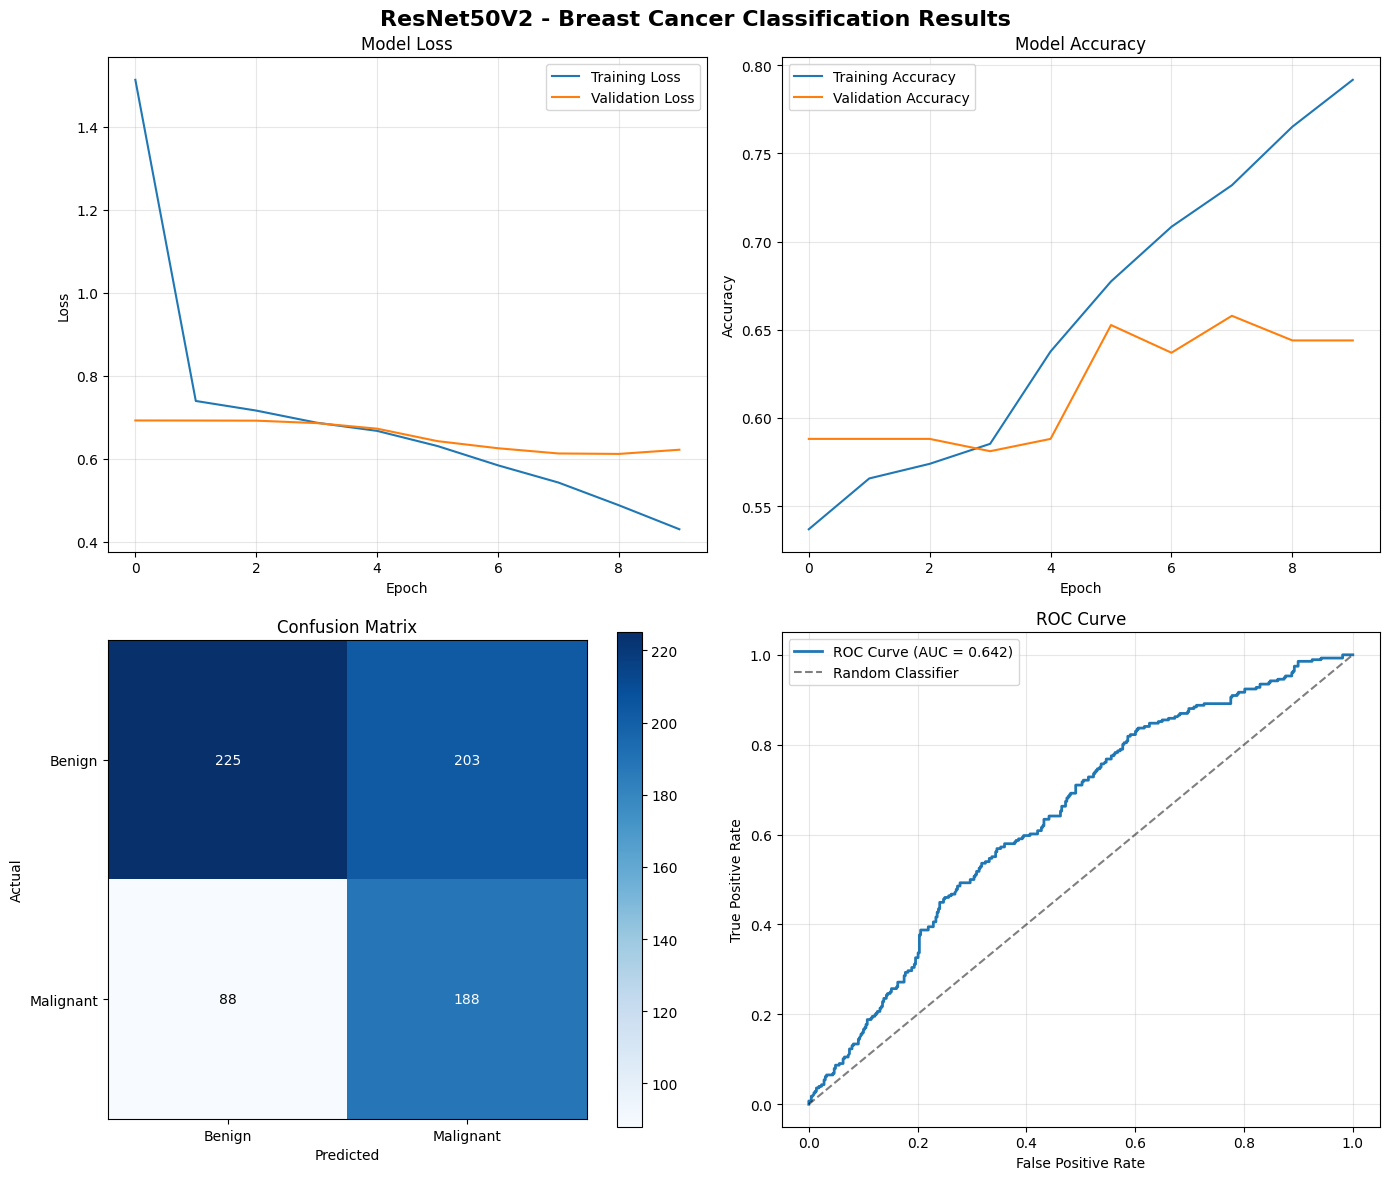

✅ Results visualization saved to d:\Computer Science\UoL\Final Project\breast-cancer-detection\figures


In [13]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 1. Training History
axes[0, 0].plot(total_history['loss'], label='Training Loss')
axes[0, 0].plot(total_history['val_loss'], label='Validation Loss')
axes[0, 0].set_title('Model Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Accuracy History
axes[0, 1].plot(total_history['accuracy'], label='Training Accuracy')
axes[0, 1].plot(total_history['val_accuracy'], label='Validation Accuracy')
axes[0, 1].set_title('Model Accuracy')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
im = axes[1, 0].imshow(cm, cmap='Blues')
axes[1, 0].set_title('Confusion Matrix')
axes[1, 0].set_xlabel('Predicted')
axes[1, 0].set_ylabel('Actual')
axes[1, 0].set_xticks([0, 1])
axes[1, 0].set_yticks([0, 1])
axes[1, 0].set_xticklabels(['Benign', 'Malignant'])
axes[1, 0].set_yticklabels(['Benign', 'Malignant'])

# Add values to confusion matrix
for (i, j), val in np.ndenumerate(cm):
    color = 'white' if val > cm.max()/2 else 'black'
    axes[1, 0].text(j, i, str(val), ha='center', va='center', color=color)

plt.colorbar(im, ax=axes[1, 0])

# 4. ROC Curve
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_true, y_prob)
axes[1, 1].plot(fpr, tpr, linewidth=2, label=f'ROC Curve (AUC = {auc:.3f})')
axes[1, 1].plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random Classifier')
axes[1, 1].set_xlabel('False Positive Rate')
axes[1, 1].set_ylabel('True Positive Rate')
axes[1, 1].set_title('ROC Curve')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle('ResNet50V2 - Breast Cancer Classification Results', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'resnet50v2_complete_results.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✅ Results visualization saved to {FIGURES_DIR}")